In [1]:
import math
import numpy
import torch
import torch.nn as nn
import torchaudio
torchaudio.set_audio_backend("soundfile")
import matplotlib.pyplot as plt

C:\Users\Jokla\anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
class AudioSample:
    def __init__(self, filepath):
        loadedData = torchaudio.load(filepath)
        self.waveform = loadedData[0][0]
        self.sampleRate = loadedData[1]
        del loadedData
        self.pitchDeltas = torch.tensor([], dtype = int)
        self.pitchBorders = torch.tensor([], dtype = int)
        self.Pitch = torch.tensor([0], dtype = int)
        self.spectra = torch.tensor([[]], dtype = float)
        self.spectrum = torch.tensor([], dtype = float)
        self.excitation = torch.tensor([], dtype = float) #replace with periodic and aperiodic excitation once implemented
        self.voicedExcitation = torch.tensor([], dtype = float)
        self.VoicedExcitations = torch.tensor([], dtype = float)
        
    def CalculatePitch(self, expectedPitch, searchRange = 0.2):
        batchSize = math.floor((1. + searchRange) * self.sampleRate / expectedPitch)
        lowerSearchLimit = math.floor((1. - searchRange) * self.sampleRate / expectedPitch)
        batchStart = 0
        while batchStart + batchSize <= self.waveform.size()[0] - batchSize:
            sample = torch.index_select(self.waveform, 0, torch.linspace(batchStart, batchStart + batchSize, batchSize, dtype = int))
            zeroTransitions = torch.tensor([], dtype = int)
            for i in range(lowerSearchLimit, batchSize):
                if (sample[i-1] < 0) and (sample[i] > 0):
                    zeroTransitions = torch.cat([zeroTransitions, torch.tensor([i])], 0)
            error = math.inf
            delta = math.floor(self.sampleRate / expectedPitch)
            for i in zeroTransitions:
                shiftedSample = torch.index_select(self.waveform, 0, torch.linspace(batchStart + i.item(), batchStart + batchSize + i.item(), batchSize, dtype = int))
                newError = torch.sum(torch.pow(sample - shiftedSample, 2))
                if error > newError:
                    delta = i.item()
                    error = newError
            self.pitchDeltas = torch.cat([self.pitchDeltas, torch.tensor([delta])])
            batchStart += delta
        nBatches = self.pitchDeltas.size()[0]
        self.pitchBorders = torch.zeros(nBatches + 1, dtype = int)
        for i in range(nBatches):
            self.pitchBorders[i+1] = self.pitchBorders[i] + self.pitchDeltas[i]
        self.Pitch = torch.mean(self.pitchDeltas.float()).int()
        del batchSize
        del lowerSearchLimit
        del batchStart
        del sample
        del zeroTransitions
        del error
        del delta
        del shiftedSample
        del newError
        del nBatches
        
    def CalculateSpectra(self, iterations = 10, filterWidth = 10, preIterations = 2):
        Window = torch.hann_window(self.Pitch * 3)
        signals = torch.stft(self.waveform, self.Pitch * 3, hop_length = self.Pitch, win_length = self.Pitch * 3, window = Window, return_complex = True)
        signals = torch.transpose(signals, 0, 1)
        signalsAbs = signals.abs()
        workingSpectra = torch.log(signalsAbs)
        workingSpectra = torch.max(workingSpectra, torch.tensor([-100]))
        self.spectra = torch.full_like(workingSpectra, -float("inf"), dtype=torch.float)
        for j in range(preIterations):
            workingSpectra = torch.max(workingSpectra, self.spectra)
            self.spectra = workingSpectra
            for i in range(filterWidth):
                self.spectra = torch.roll(workingSpectra, -i, dims = 1) + self.spectra + torch.roll(workingSpectra, i, dims = 1)
            self.spectra = self.spectra / (2 * filterWidth + 1)
        
        self.VoicedExcitations = torch.zeros_like(signals)
        for i in range(signals.size()[0]):
            for j in range(signals.size()[1]):
                if torch.log(signalsAbs[i][j]) > self.spectra[i][j]:
                    self.VoicedExcitations[i][j] = signals[i][j]
                
        for j in range(iterations):
            workingSpectra = torch.max(workingSpectra, self.spectra)
            self.spectra = workingSpectra
            for i in range(filterWidth):
                self.spectra = torch.roll(workingSpectra, -i, dims = 1) + self.spectra + torch.roll(workingSpectra, i, dims = 1)
            self.spectra = self.spectra / (2 * filterWidth + 1)
        
        self.spectrum = torch.mean(self.spectra, 0)
        for i in range(self.spectra.size()[0]):
            self.spectra[i] = self.spectra[i] - self.spectrum
        
        del Window
        del signals
        del workingSpectra
        
    def CalculateExcitation(self, filterWidth = 10):
        Window = torch.hann_window(self.Pitch * 3)
        signals = torch.stft(self.waveform, self.Pitch * 3, hop_length = self.Pitch, win_length = self.Pitch * 3, window = Window, return_complex = True)
        signals = torch.transpose(signals, 0, 1)
        excitations = torch.empty_like(signals)
        for i in range(excitations.size()[0]):
            excitations[i] = signals[i] / (torch.exp(self.spectrum) + torch.exp(self.spectra[i]))
            self.VoicedExcitations[i] = self.VoicedExcitations[i] / (torch.exp(self.spectrum) + torch.exp(self.spectra[i]))
        
        #VoicedExcitations = self.VoicedExcitations.abs()
        #for i in range(filterWidth):
        #        VoicedExcitations = torch.roll(self.VoicedExcitations.abs(), -i, dims = 1) + VoicedExcitations + torch.roll(self.VoicedExcitations.abs(), i, dims = 1)
        #self.VoicedExcitations = self.VoicedExcitations * (self.VoicedExcitations.abs() - VoicedExcitations)
        
        VoicedExcitations = torch.transpose(self.VoicedExcitations, 0, 1)
            
        excitations = torch.transpose(excitations, 0, 1)
        self.excitation = torch.istft(excitations, self.Pitch * 3, hop_length = self.Pitch, win_length = self.Pitch * 3, window = Window, onesided = True)
        self.voicedExcitation = torch.istft(VoicedExcitations, self.Pitch * 3, hop_length = self.Pitch, win_length = self.Pitch * 3, window = Window, onesided = True)
        
        self.excitation = self.excitation - self.voicedExcitation
        
        del Window
        del signals
        del excitations

In [3]:
class Synthesizer:
    def __init__(self, Excitation, Spectrum, Spectra, SampleRate):
        self.excitation = Excitation
        self.spectrum = Spectrum
        self.spectra = Spectra
        self.sampleRate = SampleRate
        self.returnSignal = torch.tensor([], dtype = float)
        
    def Synthesize(self, pitch, steadiness):
        Window = torch.hann_window(pitch * 3)
        self.returnSignal = torch.stft(self.excitation, pitch * 3, hop_length = pitch, win_length = pitch * 3, window = Window, return_complex = True)
        self.returnSignal = torch.transpose(self.returnSignal, 0, 1)
        for i in range(self.spectra.size()[0]):
            self.returnSignal[i] = self.returnSignal[i] * (torch.exp(self.spectrum) + math.pow(1 - steadiness, 2) * torch.roll(torch.exp(self.spectra), 0, dims=0)[i])
        self.returnSignal = torch.transpose(self.returnSignal, 0, 1)
        self.returnSignal = torch.istft(self.returnSignal, pitch * 3, hop_length = pitch, win_length = pitch * 3, window = Window, onesided=True, )
        del Window
        
    def save(self, filepath):
        torchaudio.save(filepath, torch.unsqueeze(self.returnSignal, 0), self.sampleRate, format="wav", encoding="PCM_S", bits_per_sample=32)

In [4]:
class RelLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(RelLoss, self).__init__()
 
    def forward(self, inputs, targets):    
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        differences = torch.abs(inputs - targets)
        sums = torch.abs(inputs + targets)
        out = (differences / sums).sum() / inputs.size()[0]
        return out

In [5]:
class SpecCrfAi(nn.Module):
    def __init__(self, learningRate=1e-5):
        super(SpecCrfAi, self).__init__()
        
        self.layer1 = torch.nn.Conv2d(1, 10, (51, 3), padding = (25, 0), bias = False)
        self.ReLu1 = nn.ReLU()
        self.layer2 = torch.nn.Conv2d(10, 10, (51, 1), padding = (25, 0), bias = False)
        self.ReLu2 = nn.ReLU()
        self.layer3 = torch.nn.Conv2d(10, 10, (51, 1), padding = (25, 0), bias = False)
        self.ReLu3 = nn.ReLU()
        self.layer4 = torch.nn.Conv2d(10, 1, (51, 1), padding = (25, 0), bias = False)
        
        self.learningRate = learningRate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learningRate, weight_decay=0.)
        #self.criterion = nn.L1Loss()
        self.criterion = RelLoss()
        
    def forward(self, spectrum1, spectrum2, factor):
        fac = torch.full((spectrum1.size()[0], 1), factor)
        x = torch.cat((spectrum1.unsqueeze(1), fac, spectrum2.unsqueeze(1)), dim = 1)
        x = x.float().unsqueeze(0).unsqueeze(0)
        x = self.layer1(x)
        x = self.ReLu1(x)
        x = self.layer2(x)
        x = self.ReLu2(x)
        x = self.layer3(x)
        x = self.ReLu3(x)
        x = self.layer4(x)
        return x
    
    def processData(self, spectrum1, spectrum2, factor):
        output = torch.squeeze(self(spectrum1, spectrum2, factor))
        return output
    
    def train(self, indata, epochs=1):
        for epoch in range(epochs):
            for data in self.dataLoader(indata):
                spectrum1 = data[0]
                spectrum2 = data[-1]
                indexList = numpy.arange(0, data.size()[0], 1)
                numpy.random.shuffle(indexList)
                for i in indexList:
                    factor = i / float(data.size()[0])
                    spectrumTarget = data[i]
                    output = torch.squeeze(self(spectrum1, spectrum2, factor))
                    loss = self.criterion(output, spectrumTarget)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
            print('epoch [{}/{}], loss:{:.4f}'
                  .format(epoch + 1, epochs, loss.data))
            
    def dataLoader(self, data):
        return torch.utils.data.DataLoader(dataset=data, shuffle=True)

In [6]:
class Synthesizer2:
    def __init__(self, SampleRate):
        self.sampleRate = SampleRate
        self.returnSignal = torch.tensor([], dtype = float)
        
    def Synthesize(self, steadiness, Spectrum, SpectraElement, Excitation):
        #Window = torch.hann_window(pitch * 3)
        modSpectrum = torch.exp(Spectrum) + math.pow(1 - steadiness, 2) * torch.roll(torch.exp(SpectraElement), 0, dims=0)
        modSpectrum = torch.cat((modSpectrum, torch.flip(modSpectrum, [0])[1:-1]), dim = 0)
        #print(Excitation.size())
        #print(modSpectrum.size())
        result = torch.fft.fft(Excitation) * modSpectrum
        result = torch.fft.ifft(result)
        return result
        
    def SynthesizeBatch(self, steadiness, Spectrum, Spectra, Excitation):
        poles = [0]
        waveforms = []
        self.returnSignal = torch.zeros_like(Excitation)
        for i in range(len(Spectra) - 1):
            delta = (Spectra[i].size()[0] * 2 - 1) / 3
            poles.append(poles[i] + delta)
            if 2 * poles[i] - poles[i+1] < 0.:
                ExcitationSegment = torch.cat((Excitation[int(2 * poles[i] - poles[i+1]):-1], Excitation[0:int(2 * poles[i+1] - poles[i])]), dim=0)#corr
            elif 2 * poles[i+1] - poles[i] > Excitation.size()[0]:
                ExcitationSegment = torch.cat((Excitation[int(2 * poles[i] - poles[i+1]):-1], Excitation[0:int(2 * poles[i+1] - poles[i] - Excitation.size()[0] + 1)]), dim=0)#corr
            else:
                ExcitationSegment = Excitation[int(2 * poles[i] - poles[i+1]):int(2 * poles[i+1] - poles[i] - 1)]
            result = self.Synthesize(steadiness, Spectrum[i], Spectra[i], ExcitationSegment)
            waveforms.append(result)
        
        for i in range(len(Spectra) - 1):
            pole1 = int((poles[i] + poles[i-1]) / 2)
            pole2 = int((poles[i+1] + poles[i]) / 2)
            if i < len(Spectra) - 2:
                pole3 = int((poles[i+2] + poles[i+1]) / 2)
            waveformStart = int(2 * poles[i] - poles[i+1])
            waveformEnd = int(2 * poles[i+1] - poles[i])
            if i == 0:
                waveforms[i][0:int(poles[i]-waveformStart)] = 0.
            elif waveformStart > pole1:
                for x in range(waveformStart, pole2):
                    AscSlope = math.pow(math.sin((x-waveformStart) * 0.5 * math.pi / (pole2-waveformStart)), 2)
                    waveforms[i][x-waveformStart] = waveforms[i][x-waveformStart] * AscSlope
            elif 2 * poles[i] - poles[i-1] < pole2:
                waveforms[i][0:pole1-waveformStart] = 0.
                for x in range(pole1, 2 * poles[i] - poles[i-1]):
                    AscSlope = math.pow(math.sin((x-pole1) * 0.5 * math.pi / (2 * poles[i] - poles[i-1]-pole1)), 2)
                    waveforms[i][x-waveformStart] = waveforms[i][x-pole1] * AscSlope
            else:
                waveforms[i][0:pole1-waveformStart] = 0.
                for x in range(pole1, pole2):
                    AscSlope = math.pow(math.sin((x-pole1) * 0.5 * math.pi / (pole2-pole1)), 2)
                    waveforms[i][x-waveformStart] = waveforms[i][x-waveformStart] * AscSlope
            if i == len(Spectra) - 2:
                waveforms[i][int(poles[i+1]-waveformStart):-1] = 0.
            elif waveformEnd < pole3:
                for x in range(pole2, waveformEnd):
                    DescSlope = math.pow(math.cos((x-pole2) * 0.5 * math.pi / (waveformEnd-pole2)), 2)
                    waveforms[i][x-waveformStart] = waveforms[i][x-waveformStart] * DescSlope
            elif 2 * poles[i+1] - poles[i+2] > pole2:
                waveforms[i][pole3-waveformEnd:-1] = 0.
                for x in range(pole2, pole3):
                    DescSlope = math.pow(math.cos((x - 2 * poles[i+1] + poles[i+2]) * 0.5 * math.pi / (pole3 - 2 * poles[i+1] + poles[i+2])), 2)
                    waveforms[i][x-waveformStart] = waveforms[i][x-waveformStart] * DescSlope
            else:
                waveforms[i][pole3-waveformEnd:-1] = 0.
                for x in range(pole2, pole3):
                    DescSlope = math.pow(math.cos((x-pole2) * 0.5 * math.pi / (pole3-pole2)), 2)
                    waveforms[i][x-waveformStart] = waveforms[i][x-waveformStart] * DescSlope
            if waveformStart < 0:
                self.returnSignal[0:waveformEnd] = self.returnSignal[0:waveformEnd] + waveforms[i][-1-waveformEnd:-1]#corr
            elif waveformEnd > self.returnSignal.size()[0]:
                self.returnSignal[waveformStart:-1] = self.returnSignal[waveformStart:-1] + waveforms[i][0:self.returnSignal.size()[0] - waveformStart]#corr
            else:
                self.returnSignal[waveformStart + 1:waveformEnd] = self.returnSignal[waveformStart + 1:waveformEnd] + waveforms[i]
            
            
    def save(self, filepath):
        torchaudio.save(filepath, torch.unsqueeze(self.returnSignal, 0).detach(), self.sampleRate, format="wav", encoding="PCM_S", bits_per_sample=32)

In [7]:
PhonemeSamples = dict([])
PhonemeKeys = ["A", "E", "I", "O", "U", "G", "K", "N", "S", "T"]

for key in PhonemeKeys:
    PhonemeSamples[key] = AudioSample("Samples_rip/"+key+".wav")
    PhonemeSamples[key].CalculatePitch(252.)
    PhonemeSamples[key].Pitch = 385
    PhonemeSamples[key].CalculateSpectra(iterations = 25)
    PhonemeSamples[key].CalculateExcitation()

TrainingSamples = dict([])
TrainingKeys = ["A_E", "A_G", "A_I", "A_K", "A_N", "A_O", "A_S", "A_T", "A_U",
                   "E_A", "E_G", "E_I", "E_K", "E_N", "E_O", "E_S", "E_T", "E_U",
                   "I_A", "I_E", "I_G", "I_K", "I_N", "I_O", "I_S", "I_T", "I_U",
                   "O_A", "O_E", "O_G", "O_I", "O_K", "O_N", "O_S", "O_T", "O_U",
                   "U_A", "U_E", "U_G", "U_I", "U_K", "U_N", "U_O", "U_S", "U_T",
                   "G_A", "G_E", "G_I", "G_O", "G_U",
                   "K_A", "K_E", "K_I", "K_O", "K_U",
                   "N_A", "N_E", "N_I", "N_O", "N_U",
                   "S_A", "S_E", "S_I", "S_O", "S_U",
                   "T_A", "T_E", "T_I", "T_O", "T_U"
                  ]

for key in TrainingKeys:
    TrainingSamples[key] = AudioSample("Samples_rip/"+key+".wav")
    TrainingSamples[key].CalculatePitch(252.)
    TrainingSamples[key].CalculateSpectra(iterations = 25)
    TrainingSamples[key].CalculateExcitation()

In [54]:
trainSpectra = []
i = 0
for key in TrainingKeys:
    trainSpectra.append(torch.empty_like(TrainingSamples[key].spectra))
    for j in range(TrainingSamples[key].spectra.size()[0]):
        trainSpectra[i][j] = TrainingSamples[key].spectrum + TrainingSamples[key].spectra[j]
    i += 1
    
specCrfAi = SpecCrfAi(learningRate=1e-5)
for i in range(70):
    specCrfAi.train(trainSpectra[i], epochs = 2)

epoch [1/2], loss:1.0597
epoch [2/2], loss:1.0399
epoch [1/2], loss:1.0243
epoch [2/2], loss:1.0451
epoch [1/2], loss:1.0471
epoch [2/2], loss:1.0945
epoch [1/2], loss:1.0156
epoch [2/2], loss:1.0016
epoch [1/2], loss:0.9906
epoch [2/2], loss:0.9717
epoch [1/2], loss:0.9757
epoch [2/2], loss:0.9731
epoch [1/2], loss:0.9733
epoch [2/2], loss:0.9618
epoch [1/2], loss:0.9528
epoch [2/2], loss:0.9557
epoch [1/2], loss:0.9528
epoch [2/2], loss:0.9513
epoch [1/2], loss:1.0171
epoch [2/2], loss:1.0568
epoch [1/2], loss:1.0787
epoch [2/2], loss:0.9724
epoch [1/2], loss:0.9967
epoch [2/2], loss:0.9974
epoch [1/2], loss:0.9719
epoch [2/2], loss:0.9720
epoch [1/2], loss:1.0079
epoch [2/2], loss:0.9724
epoch [1/2], loss:0.9877
epoch [2/2], loss:0.9705
epoch [1/2], loss:0.9936
epoch [2/2], loss:1.0149
epoch [1/2], loss:0.9738
epoch [2/2], loss:0.9831
epoch [1/2], loss:0.9833
epoch [2/2], loss:1.0584
epoch [1/2], loss:0.9707
epoch [2/2], loss:0.9873
epoch [1/2], loss:1.0267
epoch [2/2], loss:1.0671


In [8]:
Testspectrum = []
Testspectra = []
Testexcitation = torch.tensor([])
for i in range(50):
    Testspectrum.append(PhonemeSamples["A"].spectrum)
    Testspectra.append(PhonemeSamples["A"].spectra[i])
for i in range(50 * PhonemeSamples["A"].Pitch):
    Testexcitation = torch.cat((Testexcitation, PhonemeSamples["A"].excitation[i].unsqueeze(0)), dim=0)
    
for i in range(40):
    Testspectrum.append(PhonemeSamples["N"].spectrum)
    Testspectra.append(PhonemeSamples["N"].spectra[i + 0])
for i in range(0, 40 * PhonemeSamples["N"].Pitch + 0):
    Testexcitation = torch.cat((Testexcitation, PhonemeSamples["N"].excitation[i].unsqueeze(0)), dim=0)
    
for i in range(50):
    Testspectrum.append(PhonemeSamples["A"].spectrum)
    Testspectra.append(PhonemeSamples["A"].spectra[i + 70])
for i in range(70, 50 * PhonemeSamples["A"].Pitch + 70):
    Testexcitation = torch.cat((Testexcitation, PhonemeSamples["A"].excitation[i].unsqueeze(0)), dim=0)
    
for i in range(20):
    Testspectrum.append(PhonemeSamples["T"].spectrum)
    Testspectra.append(PhonemeSamples["T"].spectra[i + 0])
for i in range(0, 20 * PhonemeSamples["T"].Pitch + 0):
    Testexcitation = torch.cat((Testexcitation, PhonemeSamples["T"].excitation[i].unsqueeze(0)), dim=0)
    
for i in range(50):
    Testspectrum.append(PhonemeSamples["A"].spectrum)
    Testspectra.append(PhonemeSamples["A"].spectra[i + 154])
for i in range(154, 50 * PhonemeSamples["A"].Pitch + 154):
    Testexcitation = torch.cat((Testexcitation, PhonemeSamples["A"].excitation[i].unsqueeze(0)), dim=0)
    
for i in range(40, 60):
    Testspectrum[i] = specCrfAi.processData(Testspectrum[39], Testspectrum[60], 0.05 * (i - 40))
    
for i in range(85, 95):
    Testspectrum[i] = specCrfAi.processData(Testspectrum[84], Testspectrum[95], 0.1 * (i - 85))
    
for i in range(135, 145):
    Testspectrum[i] = specCrfAi.processData(Testspectrum[134], Testspectrum[145], 0.1 * (i - 135))
    
for i in range(155, 165):
    Testspectrum[i] = specCrfAi.processData(Testspectrum[154], Testspectrum[165], 0.1 * (i - 155))

NameError: name 'specCrfAi' is not defined

In [69]:
synthesizer2 = Synthesizer2(PhonemeSamples["A"].sampleRate)
synthesizer2.SynthesizeBatch(-1., Testspectrum, Testspectra, Testexcitation)
synthesizer2.save("Output_S2.wav")

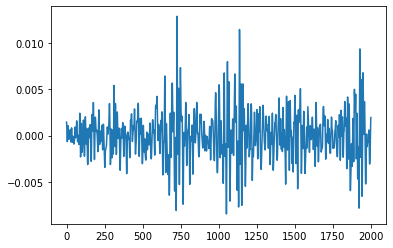

In [70]:
plt.plot(PhonemeSamples["A"].excitation[0:2000])

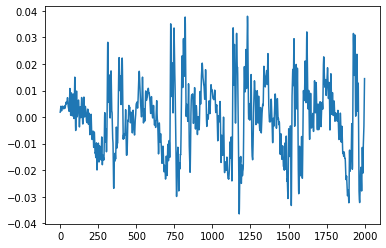

In [71]:
plt.plot(PhonemeSamples["A"].voicedExcitation[0:2000])

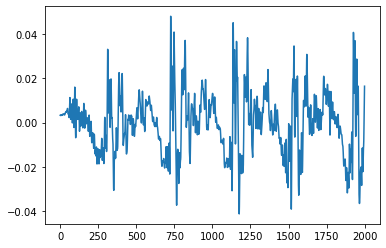

In [72]:
plt.plot(PhonemeSamples["A"].voicedExcitation[0:2000] + PhonemeSamples["A"].excitation[0:2000])

In [11]:
Testspectrum[0].size()

torch.Size([578])